In [2]:
using LinearAlgebra
using Plots
using Printf

In [3]:
# Pkg.update("Plots")

In [4]:
control_pts = [(0,0),(1,1),(2,3),(1,4),(0,4),(-1,3),(0,1),(1,0)]

8-element Vector{Tuple{Int64, Int64}}:
 (0, 0)
 (1, 1)
 (2, 3)
 (1, 4)
 (0, 4)
 (-1, 3)
 (0, 1)
 (1, 0)

![](bezier_d2.gif)

## Definitions

Bezier curve is represented as parametric function $B(t)$, where at each $t$ function value is weighted sum of control points $P_i$. The equation of Bezier curve is then:

$P(t) = \sum_{i=0}^n P_i B_i^n(t), t\in[0, 1]$,

where the weights $B_i^n(t)$ are Bernstein polynomials defined as:

$B_i^n(t) = \binom n i(1-t)^{n-i}t^i$.

Numerically stable way to evaluate Bezier curve is to use deCasteljeu algorithm, which uses recursive evaluations to get final result. Scheme of evaluations is shown on image below:

<img src="bez.png" width="700">

The equations of algorithm are:

$P_i^0 = P_i$ and 

$P_i^n(t) = (1-t)P^{n-1}_{i-1} + t P_i^{n-1}$,

then the reuslt is

$P(t) = P_n^n(t)$.

Derivative of n-order Bezier curve is (n-1) order Bezier curve $dP(t)$ with control points points $D_i$ defined as:

$D_i = n(P_i+1 - P_i)$.

The above equations are used for computation of functions `B(t, b)`and `dB(t, b)` that evaluate Bezier function and its derivative at some parameter `t`.

In [5]:
"""
    Bezier(points, points_dx, n)

Define n-order Bezier curve by its n control points `points` and its derivative (n-1)-order Bezier curve with (n-1) control points `points_dx`
"""
struct Bezier
    points::Matrix{Float64}
    points_dx::Matrix{Float64}
    n::Int
end

"""
    B(t, bc)

Evaluate Bezier curve at parameter t. Returns x and y position.
"""
function B(t, bc::Bezier)
    b = deepcopy(bc.points)
    for i=1:bc.n 
        for j=1:bc.n-i
            b[j,:] = (1-t)*b[j,:] + t*b[j+1,:]
        end
    end
    return b[1,:]
end

"""
    dB(t, bc)

Evaluate derivative of Bezier curve at parameter t. Returns x and y position.
"""
function dB(t, bc::Bezier)
    b = deepcopy(bc.points_dx)
    for i=1:(bc.n-1) 
        for j=1:(bc.n-1)-i
            b[j,:] = (1-t)*b[j,:] + t*b[j+1,:]
        end
    end
    return b[1,:]
end

"""
    compute_pts(bc, num)

Evaluate Bezier curve `num` times. Returns x and y positions.
"""
function compute_pts(bc::Bezier, num=100)
    t = LinRange(0, 1, num)
    x = zeros((num, 2))
    for ti=1:num
        x[ti, :] = B(t[ti], bc) 
    end
    return x
end


compute_pts

In [6]:
# convert to matrix
pts = [control_pts[i][j] for i=1:length(control_pts), j=1:2]

n = size(pts)[1] - 1
pts_dx = [n.*(pts[i+1, j]-pts[i, j]) for i=1:n, j=1:2]

7×2 Matrix{Int64}:
  7    7
  7   14
 -7    7
 -7    0
 -7   -7
  7  -14
  7   -7

In [7]:
n = size(pts_dx)[1] - 1
pts_ddx = [n.*(pts_dx[i+1, j]-pts_dx[i, j]) for i=1:n, j=1:2]

6×2 Matrix{Int64}:
   0   42
 -84  -42
   0  -42
   0  -42
  84  -42
   0   42

In [8]:
n = size(pts_ddx)[1] - 1
pts_dddx = [n.*(pts_ddx[i+1, j]-pts_ddx[i, j]) for i=1:n, j=1:2]

5×2 Matrix{Int64}:
 -420  -420
  420     0
    0     0
  420     0
 -420   420

In [9]:
n = size(pts_dddx)[1] - 1
pts_ddddx = [n.*(pts_dddx[i+1, j]-pts_dddx[i, j]) for i=1:n, j=1:2]

4×2 Matrix{Int64}:
  3360  1680
 -1680     0
  1680     0
 -3360  1680

In [10]:
n = size(pts_ddddx)[1] - 1
pts_dddddx = [n.*(pts_ddddx[i+1, j]-pts_ddddx[i, j]) for i=1:n, j=1:2]

3×2 Matrix{Int64}:
 -15120  -5040
  10080      0
 -15120   5040

In [11]:
bc4 = Bezier(pts_ddddx, pts_dddddx, size(pts_ddddx)[1]) # 4th derivative curve

Bezier([3360.0 1680.0; -1680.0 0.0; 1680.0 0.0; -3360.0 1680.0], [-15120.0 -5040.0; 10080.0 0.0; -15120.0 5040.0], 4)

In [16]:
# initialize our curve
bc = Bezier(pts, pts_dx, size(pts)[1])

Bezier([0.0 0.0; 1.0 1.0; … ; 0.0 1.0; 1.0 0.0], [7.0 7.0; 7.0 14.0; … ; 7.0 -14.0; 7.0 -7.0], 8)

In [17]:
"""
    self_intersect(bc, iters)

Returns self intersection curve parameters and visualization of search. Use Newton method for `iters` iterations.
"""
function self_intersect(bc, iters=10)
    function f(t, s, b)
        x1, y1 = B(t, b)
        x2, y2 = B(s, b)
        return [x1 - x2, y1 - y2]
    end

    function Jf(t, s, b)
        x1, y1 = dB(t, b)
        x2, y2 = dB(s, b)
        return [x1 -x2; y1 -y2]
    end

    x = compute_pts(bc)
    plot(x[:, 1], x[:, 2])
    t0 = 0
    s0 = 1
    x1, y1 = B(t0, bc)
    x2, y2 = B(s0, bc)
    plot!([x1, x2], [y1, y2], marker=:circle)
    for i=1:iters
        @printf("%.12f | %.12f\n", t0, s0)
        t0, s0 = [t0, s0] - Jf(t0, s0, bc)\f(t0, s0, bc)
        x1, y1 = B(t0, bc)
        x2, y2 = B(s0, bc)
        plot!([x1, x2], [y1, y2], marker=:circle)
    end
    @printf("intersection points: t (x, y)\n %.10f:(%.10f, %.10f)\n %.10f:(%.10f, %.10f)", t0, x1, y1, s0, x2, y2)

    p = plot!(legend=false, axisratio=:equal)
    return [t0, s0, p]
end

self_intersect

## Intersection

Compute self intersection of Bezier curve so that we know where the loop starts.
We used Newton's iterative method with start points at the end of the curves.

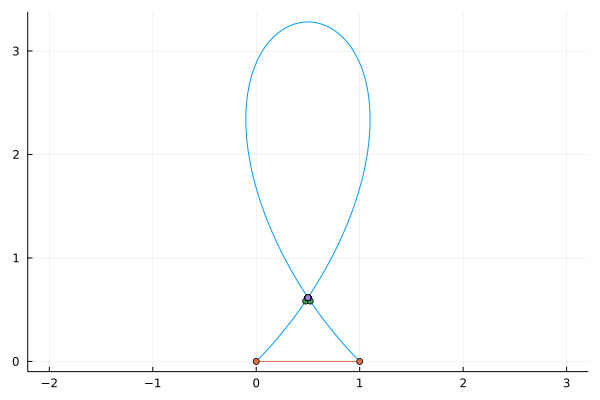

0.000000000000 | 1.000000000000
0.071428571429 | 0.928571428571
0.075039982563 | 0.924960017437
0.075064349454 | 0.924935650546
0.075064350589 | 0.924935649411
0.075064350589 | 0.924935649411
0.075064350589 | 0.924935649411
0.075064350589 | 0.924935649411
0.075064350589 | 0.924935649411
0.075064350589 | 0.924935649411
intersection points: t (x, y)
 0.0750643506:(0.5000000000, 0.6162957793)
 0.9249356494:(0.5000000000, 0.6162957793)

In [18]:
t, s, p = self_intersect(bc)
display(p)

In [31]:
"""
    integrate_simp(t, s, bc)

Get area of the loop of Bezier curve bs with self intersection at parameters t and s. Uses Simpson's method for integration.
"""
function integrate_simp(t, s, bc)

    function f(t, b)
        x, y = B(t, b)
        dx, dy = dB(t, b)
        ft = x*dy - y*dx # counterclockwise?
        return ft
    end

    function simp(a, b, bc, h)
        fa = f(a, bc)
        fb = f(b, bc)
        fab = f((a+b)/2, bc)
        cI = (fa + 4*fab + fb)
        return cI
    end

    Is = []
    st = 100:50:1200 # try different number of steps

    for j in st
        I = 0
        steps = j
        a = t
        h = (s-t)/steps
        b = a + h
        for i=1:steps
            cI = simp(a, b, bc, h)
            I += cI
            a = b
            b += h 
        end
        I *= (h/12) # from green * (1/2) and simpson * (h/6)
        append!(Is, I)
        @printf("%.15f (h: %.10f)\n", I, h)
    end
    p = plot(st, Is)
    @printf("Area of the loop: %.15f\n", last(Is))
    return [last(Is), p]
end

integrate_simp

## Integration

We determine the area of the loop by integrating the enclosing curve from t to s (assume t<s). Area integral can be written as:

$A = \iint_D dA = ... = \frac{1}{2}\oint_t^s x dy - y dx$, 

and then use Simpson's method to compute interval area as :

A(a, b) = $\frac{b-a}{12} (f(a) + 4f(\frac{a+b}{2}) + f(b))$, 

where

$f(t) = x dy - y dx$, where $x, y = B(t)$ and $dx, dy = dB(t)$.

We do this for multiple number of steps, the result quickly converges. The basic Simpson method should be enough for our problem since we have nice curve in all points except near intersection (but there we start at one end of intersection and end in another - there is no spike in our intevals, so no problems anywhere). 

Error for Simpson method is bounded such: $err \leq k\frac{(b-a)^5}{180n^4}$, if $|f^{(4)}(x)|\leq k, k\in\mathbb{R}$. 4. derivative of Bezier curve is bounded, our integral boundaries are also bounded, so we have some $K\in\mathbb{R}$ such that $err \leq \frac{K}{n^4}$. If we take $n=1000$, then $err \leq \frac{K}{10^{12}}$, in our case $K\leq13$. This should mean that our result has no mistake for the first 10 decimals.

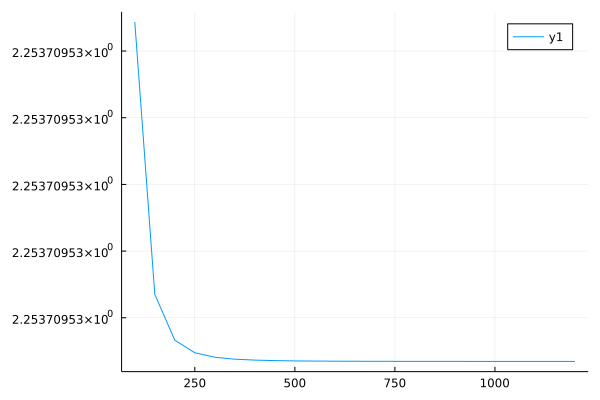

2.253709532717827 (h: 0.0084987130)
2.253709530675327 (h: 0.0056658087)
2.253709530331658 (h: 0.0042493565)
2.253709530237733 (h: 0.0033994852)
2.253709530203981 (h: 0.0028329043)
2.253709530189540 (h: 0.0024282037)
2.253709530182544 (h: 0.0021246782)
2.253709530178808 (h: 0.0018886029)
2.253709530176578 (h: 0.0016997426)
2.253709530175265 (h: 0.0015452205)
2.253709530174565 (h: 0.0014164522)
2.253709530173948 (h: 0.0013074943)
2.253709530173539 (h: 0.0012141019)
2.253709530173345 (h: 0.0011331617)
2.253709530173122 (h: 0.0010623391)
2.253709530172997 (h: 0.0009998486)
2.253709530173005 (h: 0.0009443014)
2.253709530172733 (h: 0.0008946014)
2.253709530172828 (h: 0.0008498713)
2.253709530172843 (h: 0.0008094012)
2.253709530172645 (h: 0.0007726103)
2.253709530172839 (h: 0.0007390185)
2.253709530172731 (h: 0.0007082261)
Area of the loop: 2.253709530172731


In [32]:
a, p = integrate_simp(t, s, bc)
display(p)

In [14]:
## viz script

function animate_bezier(px, py, steps=100)
    n = length(px)-1
    # saving all in between de Casteljau points
    bs = [zeros(2,r) for r=n+1:-1:0]
    # base case Bézier points
    bs[1][1,:] = px 
    bs[1][2,:] = py
    points = zeros(steps,2)
    colors = [:green,:orange,:red,:yellow, :pink, :blue, :purple, :lightgreen] 
    if length(colors) < n
        return ErrorException("add more colors!")
    end
    c = 1
    anim = @animate for t in LinRange(0,1,steps)
        plot(axisratio=:equal, legend=false)
        plot!(px, py, linetype=:scatter)
        for i=1:n
            for j=0:n-i   
                # linear interpolation between twp ponts                   
                new_b = (1-t)*bs[i][:,j+1]+t*bs[i][:,j+2]
                bs[i+1][:,j+1] = new_b
                # drawing the line for linear interpolation as well as the specific point for t
                plot!(bs[i][1,j+1:j+2],bs[i][2,j+1:j+2], legend=false, color=colors[i])
                plot!([new_b[1]],[new_b[2]], linetype=:scatter, legend=false, color=colors[i])
                if i == n
                    points[c,:] = [new_b[1],new_b[2]]
                    # draw the curve until point t = LinRange(0,1,steps)[c]
                    plot!(points[1:c,1],points[1:c,2], color=:black)
                    c += 1
                end
            end
        end
    end
    gif(anim, "bezier_d2.gif", fps=30)
end

## Visualization

# Animation script taken from (https://opensourc.es/blog/bezier-curve/) and slightly modified.
# animate_bezier(pts[:,1], pts[:, 2])

animate_bezier (generic function with 2 methods)